# Train a RNN network

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""Main script used for training."""
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
from tensorflow.keras.models import load_model
import keras.metrics
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from nmp import model as mod
from nmp import dataset, ev_metrics
from nmp.dataset import pyplot_piano_roll
from nmp import plotter
from pathlib import Path
import time
import math
import pypianoroll
from pypianoroll import Multitrack, Track
import numpy as np
import random
import copy

SAVE = 0
NOTES = '-' + 'lstm'

# P = Path(__file__).parent.absolute()
P = Path(os.path.abspath(''))  # Compatible with Jupyter Notebook
P2 = Path('S:\datasets')  # Dataset path

PLOTS = P / 'plots'  # Plots path
FS = 24  # Sampling frequency. 10 Hz = 100 ms
Q = 0  # Quantize?
st = 10  # Past timesteps
num_ts = 10  # Predicted timesteps
DOWN = 12  # Downsampling factor

# D = "data/Piano-midi.de"  # Dataset
# D = "data/Nottingham"  # Dataset
D = "data/POP909" #Dataset
# D = "data/JSB Chorales"  # Dataset
# D = "data/MuseData"  # Dataset

# 49-key keyboard
# LOW_LIM = 36  # C2
# HIGH_LIM = 85  # C6

# 64-key keyboard
LOW_LIM = 33  # A1
HIGH_LIM = 97  # C7

# Complete 88-key keyboard
# LOW_LIM = 21  # A0
# HIGH_LIM = 109  # C8

NUM_NOTES = HIGH_LIM - LOW_LIM
CROP = [LOW_LIM, HIGH_LIM]  # Crop plots

LOAD = 0
TRANS = 0

Using TensorFlow backend.


### Generate list of MIDI files

In [2]:
train_list = [x for x in os.listdir(P / D / 'train') if x.endswith('.mid')]
validation_list = [x for x in os.listdir(P / D / 'valid') if x.endswith('.mid')]

# train_list = [train_list[x] for x in range(10)]
# validation_list = [validation_list[x] for x in range(5)]

print("\nTrain list:  ", train_list)
print("\nValidation list:  ", validation_list)


Train list:   ['004.mid', '005.mid', '006.mid', '007.mid', '008.mid', '009.mid', '010.mid', '011.mid', '014.mid', '015.mid', '016.mid', '020.mid', '021.mid', '023.mid', '027.mid', '029.mid', '030.mid', '031.mid', '032.mid', '033.mid', '034.mid', '037.mid', '038.mid', '041.mid', '042.mid', '043.mid', '045.mid', '046.mid', '047.mid', '049.mid', '050.mid', '051.mid', '052.mid', '053.mid', '054.mid', '058.mid', '059.mid', '061.mid', '063.mid', '064.mid', '065.mid', '068.mid', '070.mid', '071.mid', '074.mid', '075.mid', '079.mid', '081.mid', '082.mid', '084.mid', '085.mid', '086.mid', '087.mid', '089.mid', '090.mid', '091.mid', '093.mid', '094.mid', '096.mid', '097.mid', '099.mid', '101.mid', '102.mid', '103.mid', '104.mid', '105.mid', '108.mid', '111.mid', '117.mid', '118.mid', '119.mid', '121.mid', '124.mid', '126.mid', '128.mid', '129.mid', '132.mid', '133.mid', '135.mid', '136.mid', '137.mid', '139.mid', '140.mid', '141.mid', '145.mid', '147.mid', '148.mid', '149.mid', '152.mid', '156.

## Datasets

### Generate data from lists
Training, validation and test sets.

In [3]:
start = time.time()

train = dataset.Dataset(train_list, P / D / 'train',  fs=FS, bl=0, quant=Q)
validation = dataset.Dataset(validation_list, P / D / 'valid',  fs=FS, bl=0, quant=Q)

train.build_rnn_dataset("training", down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
validation.build_rnn_dataset("validation", down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

end = time.time()
print("Done")
print("Loading time: %.2f" % (end-start))

Building training dataset (581 files)
Building validation dataset (146 files)
Done
Loading time: 270.38


In [4]:
print(train.dataset[0].shape)
print(train.dataset[1].shape)
print(validation.dataset[0].shape)
print(validation.dataset[1].shape)
# print(test.dataset[0].shape)
# print(test.dataset[1].shape)

# pyplot_piano_roll(test.dataset[1][:, :NUM_NOTES], cmap="Oranges",
#                   low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Test target")
# plt.ylim(CROP)

(380285, 1280)
(380285, 1280)
(96104, 1280)
(96104, 1280)


In [5]:
seq_length = 100
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train.dataset[0]))
train_sequences = train_dataset.batch(seq_length, drop_remainder=True)

valid_dataset = tf.data.Dataset.from_tensor_slices((validation.dataset[0]))
valid_sequences = valid_dataset.batch(seq_length, drop_remainder=True)

# test_dataset = tf.data.Dataset.from_tensor_slices((test.dataset[0]))
# test_sequences = test_dataset.batch(10, drop_remainder=True)

train_dataset

<TensorSliceDataset shapes: (1280,), types: tf.bool>

In [6]:
def split_input_target(chunk):
    input_text = chunk[:, :10*64]
    target_text = chunk[:, 10*64:]
#     tf.reshape(target_text, shape=[100, 640])
#     input_text = chunk[:-1]
#     target_text = chunk[1:]
    return input_text, target_text

def split_input_target_base(chunk):
    input_text = chunk[:,:10]
    target_text = chunk[:,10:]
#     input_text = chunk[:-1]
#     target_text = chunk[:-1]
    return input_text, target_text

train_data = train_sequences.map(split_input_target)
valid_data = valid_sequences.map(split_input_target)
# test_data = test_sequences.map(split_input_target)
# baseline_data = test_sequences.map(split_input_target_base)

train_data

<MapDataset shapes: ((100, 640), (100, 640)), types: (tf.bool, tf.bool)>

In [7]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
valid_data = valid_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
# test_data = test_data.batch(1, drop_remainder=True)
# baseline_data = baseline_data.batch(1, drop_remainder=True)
print("Train: ", train_data)
print("Valid: ", valid_data)
# print("Test: ", test_data)
# print("Baseline: ", baseline_data)

Train:  <BatchDataset shapes: ((64, 100, 640), (64, 100, 640)), types: (tf.bool, tf.bool)>
Valid:  <BatchDataset shapes: ((64, 100, 640), (64, 100, 640)), types: (tf.bool, tf.bool)>


In [8]:
for input_batch, label_batch in train_data.take(1):
    print(input_batch.shape)
    print(label_batch.shape)

(64, 100, 640)
(64, 100, 640)


### Save dataset

### Piano rolls of training dataset
Input and output piano rolls

In [11]:
# plt.rcParams["figure.figsize"] = (20, 8)
# pyplot_piano_roll(train.dataset[0][:, 0, :],
#                   low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Train data")
# plt.ylim(CROP)
# pyplot_piano_roll(train.dataset[1][:, :NUM_NOTES], cmap="Oranges",
#                   low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Train target")
# plt.ylim(CROP)

IndexError: too many indices for array

## Keras
### Build the model

In [9]:
BS = BATCH_SIZE  # Batch size
import importlib
importlib.reload(mod)
importlib.reload(dataset)
import time

In [10]:
if LOAD:
    model = load_model(filepath=model_path,
                       custom_objects=None,
                       compile=True)

else:
    # model = mod.build_gru_model(NUM_NOTES, BS)
    model = mod.build_lstm_model(NUM_NOTES, BS)
    mod.compile_model(model, 'binary_crossentropy', 'adam',
                      metrics=['accuracy'])

model.summary()

now = datetime.now()

# Save logs
logger = TensorBoard(log_dir=P / 'logs' / now.strftime("%Y%m%d-%H%M%S"),
                     write_graph=True, update_freq='epoch')

csv_logger = CSVLogger(P / 'logs' / (now.strftime("%Y%m%d-%H%M%S") + '-' +
                       str(st) + '-' + str(num_ts) + '.csv'),
                       separator=',', append=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (64, None, 128)           393728    
_________________________________________________________________
dense (Dense)                (64, None, 64)            8256      
_________________________________________________________________
Output (Dense)               (64, None, 640)           41600     
Total params: 443,584
Trainable params: 443,584
Non-trainable params: 0
_________________________________________________________________


### Try the model
Try the model before training

In [14]:
# for input_example_batch, target_example_batch in train_data.take(1):
#     example_batch_predictions = model(tf.cast(input_example_batch, tf.float32))
#     print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 490) # (batch_size, sequence_length, vocab_size)


### Checkpoints

In [11]:
# Directory where the checkpoints will be saved
checkpoint_dir = P / ('models/training_checkpoints/' + now.strftime("%Y%m%d-%H%M%S"))
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True,
    period=5)

### Fit the model
Define batch size ```BS``` and number of ```epochs```

#### fit generator

In [16]:
# # Fit generator the model.
# BS = 64  # Batch size
# epochs = 20
# start = time.time()
# size_train = math.ceil(train.dataset[0].shape[0] / BS)
# spe_train = size_train
# size_valid = math.ceil(validation.dataset[0].shape[0] / BS)
# spe_valid = size_valid
# print("Train dataset shape: ", train.dataset[0].shape, "\n")
# print("Train dataset target shape: ", train.dataset[1].shape, "\n")

# # Fit generator. Data should be shuffled before fitting.
# history = model.fit(dataset.generate((train.dataset[0], train.dataset[1]), trans=1), epochs=epochs,
#           steps_per_epoch=spe_train,
#           validation_data=dataset.generate((validation.dataset[0], validation.dataset[1])),
#           validation_steps=spe_valid,
#           callbacks=[logger, csv_logger])

# end = time.time()

Train dataset shape:  (380285, 980) 

Train dataset target shape:  (380285, 980) 



IndexError: too many indices for array

#### fit

In [12]:
# Fit the model.
BS = BATCH_SIZE  # Batch size
epochs = 20
start = time.time()

# Normal fit. Auto-shuffles data.
history = model.fit(train_data, validation_data=valid_data, epochs=epochs, shuffle=True,
                    callbacks=[logger, csv_logger, checkpoint_callback])

end = time.time()

Train for 59 steps, validate for 15 steps
Epoch 1/20
59/59 [==============================] - 8s 138ms/step - loss: 0.3441 - accuracy: 0.8717 - val_loss: 0.2630 - val_accuracy: 0.9152
Epoch 2/20
59/59 [==============================] - 4s 71ms/step - loss: 0.2577 - accuracy: 0.9157 - val_loss: 0.2536 - val_accuracy: 0.9152
Epoch 3/20
59/59 [==============================] - 7s 111ms/step - loss: 0.2350 - accuracy: 0.9157 - val_loss: 0.2260 - val_accuracy: 0.9149
Epoch 4/20
59/59 [==============================] - 11s 193ms/step - loss: 0.2224 - accuracy: 0.9155 - val_loss: 0.2231 - val_accuracy: 0.9150
Epoch 5/20
59/59 [==============================] - 12s 211ms/step - loss: 0.2205 - accuracy: 0.9155 - val_loss: 0.2217 - val_accuracy: 0.9150
Epoch 6/20
59/59 [==============================] - 13s 217ms/step - loss: 0.2191 - accuracy: 0.9157 - val_loss: 0.2203 - val_accuracy: 0.9151
Epoch 7/20
59/59 [==============================] - 12s 211ms/step - loss: 0.2174 - accuracy: 0.9158 - v

In [15]:
('rnn-' + D[5:] + '-loss-train.dat').lower()

'rnn-pop909-loss-train.dat'

In [18]:
# model.save(str(P / 'models' / 'ff-z2-de'))
model.save(str(P / 'models' / 'lstm-500') + '.h5', save_format='h5')

### History

In [13]:
print("\nTraining time: ", (end-start), "\n")
hist = pd.DataFrame(history.history)

if SAVE:
    hist['loss'].to_csv(('tables/rnn-' + D[5:] + '-loss-train' + NOTES + '.dat').lower(), sep=' ', header=None)
    hist['val_loss'].to_csv(('tables/rnn-' + D[5:] + '-loss-valid' + NOTES + '.dat').lower(), sep=' ', header=None)

hist


Training time:  190.24200081825256 



,loss,accuracy,val_loss,val_accuracy
0,0.344126,0.871679,0.263044,0.915189
1,0.257699,0.915701,0.253594,0.915218
2,0.235025,0.915736,0.225991,0.914917
3,0.222352,0.915536,0.223129,0.914967
4,0.220513,0.915534,0.221729,0.915041
5,0.219135,0.915653,0.220328,0.915101
6,0.217444,0.915769,0.218475,0.915326
7,0.214819,0.916085,0.215627,0.915777
8,0.211674,0.916521,0.212812,0.916175
9,0.208927,0.916959,0.210541,0.916453


### Plot loss function of training and validation sets

Training time:  190.24200081825256


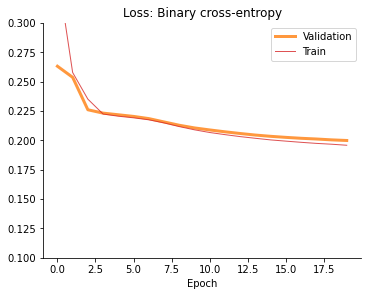

In [14]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))
plt.plot(hist['val_loss'], '-', lw=3, c='tab:orange', label='Validation', ms=8, alpha=0.8)
plt.plot(hist['loss'], '-', lw=1, c='tab:red', label='Train', ms=8, alpha=0.8)
plt.xlabel('Epoch')
# plt.xticks(range(epochs))
plt.legend()
plt.title('Loss: Binary cross-entropy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([0.1, 0.3])
# fig.savefig(PLOTS / 'compare-lstm-loss.eps', fmt='eps')
print("Training time: ", (end-start))

KeyError: 'f1'

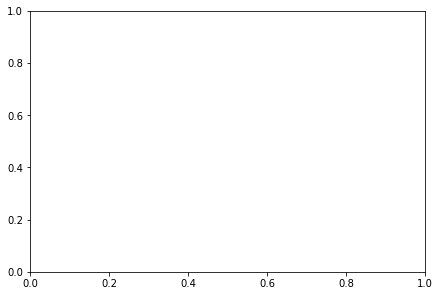

In [15]:
    # F1 score.
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))
    plt.plot(hist['f1'], 's-', c='tab:blue', label='Train', ms=8, alpha=0.8)
    plt.plot(hist['val_f1'], 'o-', c='tab:orange', label='Validation', ms=8,
             alpha=0.8)
    plt.xlabel('Epoch', fontsize='x-large')
    plt.legend(fontsize='x-large')
    plt.title('F1 Score', fontsize='x-large')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax = plt.gca()
    ax.tick_params(labelsize='x-large')


KeyError: 'precision_1'

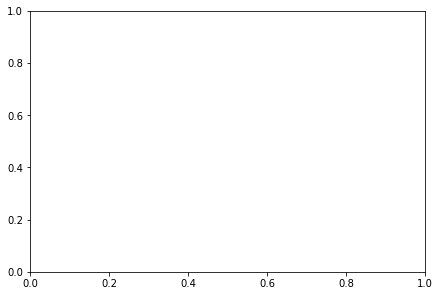

In [17]:
    # Precision
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))
    plt.plot(hist['precision_1'], 's-', c='tab:blue', label='Train', ms=8, alpha=0.8)
    plt.plot(hist['val_precision_1'], 'o-', c='tab:orange', label='Validation', ms=8, alpha=0.8)
    plt.xlabel('Epoch', fontsize='x-large')
    plt.legend(fontsize='x-large')
    plt.title('Precision', fontsize='x-large')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax = plt.gca()
    ax.tick_params(labelsize='x-large')


## Save model to file
Model can be loaded with:
``` python
load_model(filepath=str(folder_path), compile=True)
```

In [19]:
# model.save(str(P / 'models' / 'simpleRNN-nottingham-3') + '.h5', save_format='h5')
# model.save(str(P / 'models' / 'lstm-z-de') + '.h5', save_format='h5')

### Model evaluation

In [18]:
print("Evaluation on train set:")
e_train = model.evaluate(train_data)

print("\nEvaluation on validation set:")
e_valid = model.evaluate(valid_data)

# print("\nEvaluation on test set:")
# e_test = model.evaluate(test_data)

results = {out: e_train[i] for i, out in enumerate(model.metrics_names)}
res = pd.DataFrame(list(results.items()), columns=['metric', 'train'])
res = res.set_index('metric')

results2 = {out: e_valid[i] for i, out in enumerate(model.metrics_names)}
res2 = pd.DataFrame(list(results2.items()), columns=['metric', 'validation'])
res2 = res2.set_index('metric')

# results3 = {out: e_test[i] for i, out in enumerate(model.metrics_names)}
# res3 = pd.DataFrame(list(results3.items()), columns=['metric', 'test'])
# res3 = res3.set_index('metric')
res3 = pd.DataFrame([])

result = pd.concat([res, res2, res3], axis=1, sort=False)
result

Evaluation on train set:
59/59 [==============================] - 2s 42ms/step - loss: 0.1954 - accuracy: 0.9202

Evaluation on validation set:
15/15 [==============================] - 1s 40ms/step - loss: 0.1998 - accuracy: 0.9189


,train,validation
metric,,
loss,0.195365,0.199804
accuracy,0.920215,0.918923


## Make predictions
Predictions from test dataset

### Restore last checkpoint

Build again the model and restore the checkpoint with weights to use a different batch size for test.

In [19]:
# model = mod.build_gru_model(NUM_NOTES, 1)
model = mod.build_lstm_model(NUM_NOTES, 1)
mod.compile_model(model, 'binary_crossentropy', 'adam',
                  metrics=['accuracy'])
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))


In [20]:
test_list = [x for x in os.listdir(P / D / 'test') if x.endswith('.mid')]
# test_list = [test_list[x] for x in range(3)]
test = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=0, quant=Q)
test.build_rnn_dataset("test", down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
test.dataset[0].shape

Building test dataset (182 files)


(114658, 1280)

In [21]:
test_dataset = tf.data.Dataset.from_tensor_slices((test.dataset[0]))
test_sequences = test_dataset.batch(50, drop_remainder=True)
test_data = test_sequences.map(split_input_target)
test_data = test_data.batch(1, drop_remainder=True)

In [22]:
predictions = model.predict(test_data)

In [23]:
predictions_bin = dataset.ranked_threshold(predictions[:, 0, :NUM_NOTES], 1, 3)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2388f0b1f08>)

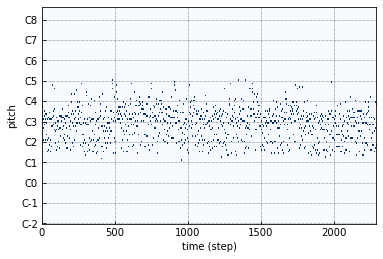

In [24]:
pyplot_piano_roll(predictions_bin, low_lim=LOW_LIM, high_lim=HIGH_LIM)

## Load tests dataset (standard way)

In [23]:
# importlib.reload(dataset)
# st = 10  # Past timesteps
# num_ts = 10  # Predicted timesteps

# test_list = [x for x in os.listdir(P / D / 'test') if x.endswith('.mid')]
# # test_list = test_list[:20]
# test = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=0, quant=Q)
# test.build_dataset("test", step=st, t_step=num_ts, steps=st,
#                    down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

Building test dataset (182 files)


KeyboardInterrupt: 

In [24]:
# print(test.dataset[0].shape)
# pyplot_piano_roll(test.dataset[0][:, 0, :], low_lim=LOW_LIM, high_lim=HIGH_LIM)

AttributeError: 'Dataset' object has no attribute 'dataset'

In [112]:
# reshaped = test.dataset[0].reshape(len(test.dataset[0]), 640)
# reshaped.shape

(114658, 640)

### Make predictions

In [25]:
# import importlib
# importlib.reload(dataset)

# rnn_predictions = []
# for c, t in enumerate(reshaped):
#     rnn_predictions.append(dataset.predict_rnn(t, model))
#     if c % 1000 == 0:
#         print("Processed timestep %d" % c)
#     pyplot_piano_roll(rnn_predictions, low_lim=LOW_LIM, high_lim=HIGH_LIM)
#     pyplot_piano_roll(t, low_lim=LOW_LIM, high_lim=HIGH_LIM)
#     break

# rnn_predictions = np.array(rnn_predictions)

NameError: name 'reshaped' is not defined

In [73]:
# pyplot_piano_roll(rnn_predictions[:, 1, :], low_lim=LOW_LIM, high_lim=HIGH_LIM)

TypeError: list indices must be integers or slices, not tuple

### Evaluate AUC-ROC
Reshape predictions

In [25]:
# predictions = rnn_predictions.reshape([len(rnn_predictions), 640])


In [115]:
# # # Build baseline
# L = test.dataset[0].shape[0]
# baseline = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=1, quant=Q)
# baseline.build_dataset("baseline", step=st, t_step=num_ts, steps=st,
#                        down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

# print("")
# print("Baseline shape: ", baseline.dataset[1].shape)
# print("Test shape: ", test.dataset[1].shape)

# pred_auc = ev_metrics.compute_auc(test.dataset[1][:L, :], predictions, NUM_NOTES)
# base_auc = ev_metrics.compute_auc(test.dataset[1][:L, :], baseline.dataset[1][:L, :], NUM_NOTES)

Building baseline dataset (182 files)

Baseline shape:  (114658, 640)
Test shape:  (114658, 640)


(64, 10)


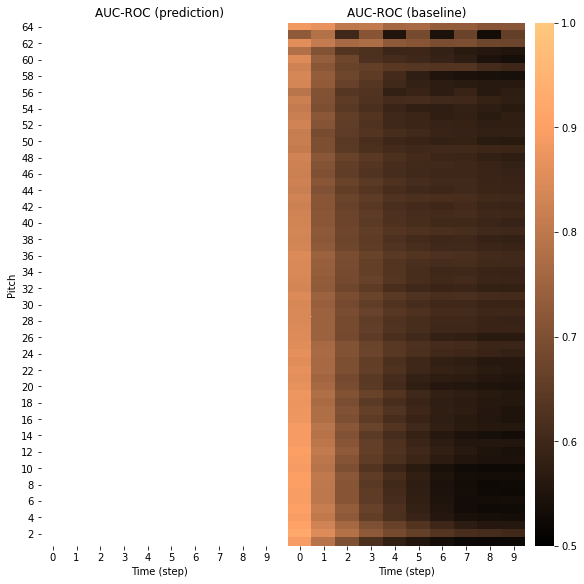

In [118]:
# fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
#                                      figsize=(8, 8),
#                                      gridspec_kw={'width_ratios':[1, 1, 0.08]})
# g1 = sns.heatmap(pred_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax1, cbar=False)
# g1.set_ylabel('')
# g1.set_xlabel('')
# g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
# ax1.set_xlabel('Time (step)')
# ax1.set_ylabel('Pitch')
# ax1.set_title('AUC-ROC (prediction)')
# g2 = sns.heatmap(base_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax2, cbar_ax=axcb)
# g2.set_ylabel('')
# g2.set_xlabel('')
# g2.set_yticks([])
# ax2.set_xlabel('Time (step)')
# ax2.set_title('AUC-ROC (baseline)')
# ax1.get_shared_y_axes().join(ax1,ax2)
# # plt.savefig(PLOTS / 'heat.eps', format='eps')
# print(pred_auc.shape)

(64, 10)


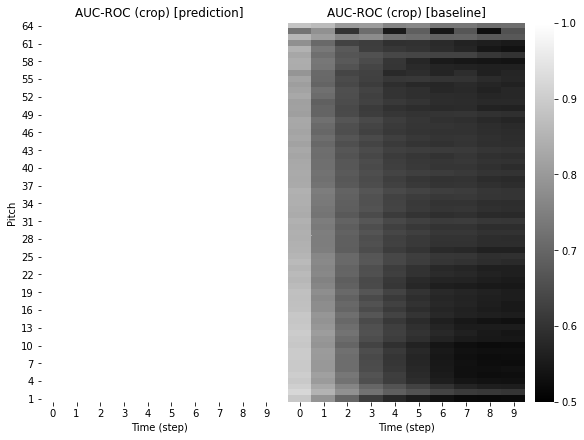

In [119]:
# c1 = 0
# c2 = 64
# fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
#                                      figsize=(8, 6),
#                                      gridspec_kw={'width_ratios':[1, 1, 0.08]})
# g1 = sns.heatmap(pred_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax1, cbar=False)
# g1.set_ylabel('')
# g1.set_xlabel('')
# g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
# ax1.set_xlabel('Time (step)')
# ax1.set_ylabel('Pitch')
# ax1.set_title('AUC-ROC (crop) [prediction]')
# g2 = sns.heatmap(base_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax2, cbar_ax=axcb)
# g2.set_ylabel('')
# g2.set_xlabel('')
# g2.set_yticks([])
# ax2.set_xlabel('Time (step)')
# ax2.set_title('AUC-ROC (crop) [baseline]')
# ax1.get_shared_y_axes().join(ax1,ax2)
# # plt.savefig(PLOTS / 'heat_crop.eps', format='eps')
# print(pred_auc.shape)

Predict. mean value: nan
Baseline mean value: 0.65001027272377


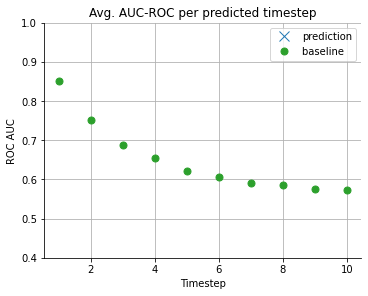

In [120]:
# fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))

# ax.plot(range(1, num_ts + 1), np.mean(pred_auc[c1:c2]), 'x', c='tab:blue', label='prediction', ms=10)
# ax.plot(range(1, num_ts + 1), np.mean(base_auc[c1:c2]), 'o', c='tab:green', label='baseline ', ms=7)

# ax.set_ylim([0.4, 1])
# ax.set_ylim([0.4, 1])
# ax.legend()
# plt.title('Avg. AUC-ROC per predicted timestep')
# plt.xlabel('Timestep')
# # plt.xticks([0, 2, 4, 6, 8, 10])
# plt.ylabel('ROC AUC')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# name = 'auc' + str()
# plt.grid()
# # plt.savefig(PLOTS / 'rnn10.eps', format='eps')

# print("Predict. mean value:", np.mean(np.mean(pred_auc[c1:c2])))
# print("Baseline mean value:", np.mean(np.mean(base_auc[c1:c2])))

In [37]:
# np.mean(pred_auc[c1:c2])

In [38]:
# np.mean(base_auc[c1:c2])

# Other 

In [26]:
model.reset_states()
predauc = []
baseauc = []

merged_input = []
merged_output = []
merged_pred = []

for input_batch, label_batch in test_data.take(-1):
    predictions = model(tf.cast(input_batch, tf.float32))

    pred = np.array(tf.squeeze(predictions, 0))
    inp = np.array(tf.squeeze(input_batch, 0))
    out = np.array(tf.squeeze(label_batch, 0))

    # Merged piano rolls to compute overall AUC.
    merged_input.append(inp)
    merged_output.append(out)
    merged_pred.append(pred)

merged_input = np.concatenate([x for x in merged_input])
merged_output = np.concatenate([x for x in merged_output])
merged_pred = np.concatenate([x for x in merged_pred])

# merged_input = merged_input.reshape((len(merged_input), 10, 64))
# merged_output = merged_output.reshape((len(merged_output), 10, 64))
# merged_pred = merged_pred.reshape((len(merged_pred), 10, 64))

print(merged_input.shape)

baseline = copy.deepcopy(merged_input)
for t in range(len(merged_input)):
    for s in range(10):
        baseline[t, 64*s:64*(s+1)] = merged_input[t, 640-64:640]

pred_auc = ev_metrics.compute_auc(merged_output, merged_pred, NUM_NOTES)
base_auc = ev_metrics.compute_auc(merged_output, baseline, NUM_NOTES)

# print("Pred AUC-ROC (mean of subsets): ", np.mean(predauc))
# print("Base AUC-ROC:(mean of subsets): ", np.mean(baseauc))

# print("Pred AUC-ROC (global): ", np.mean(np.mean((pred_auc_merged))))
# print("Base AUC-ROC (global): ", np.mean(np.mean((base_auc_merged))))


# # pyplot_piano_roll(test.dataset[1][:, :NUM_NOTES],
# #                   cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Test target (ground truth)")


# plt.rcParams["figure.figsize"] = (13, 4)
# pyplot_piano_roll(merged_output,
#                   cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Target (labels)")
# plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll1.png")
# pyplot_piano_roll(merged_pred[:, :NUM_NOTES],
#                   cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Predictions")
# plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll2.png")
# pyplot_piano_roll(merged_input[:, :NUM_NOTES],
#                   cmap="Reds", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# plt.title("Baseline (equal to inputs)")
# plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll3.png")


(114650, 640)


(64, 10)


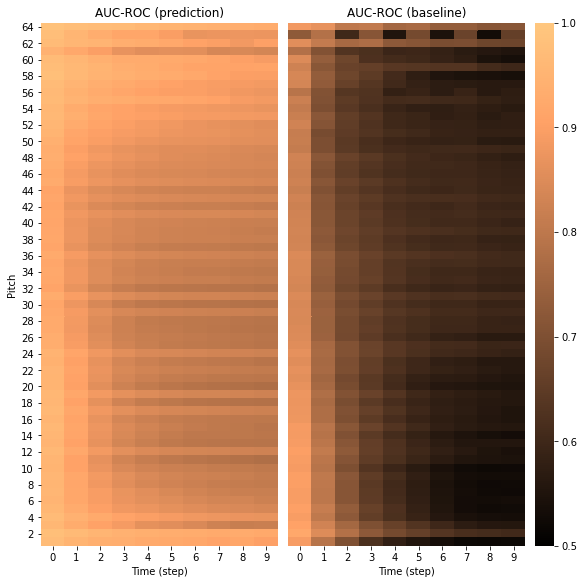

In [58]:
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
                                     figsize=(8, 8),
                                     gridspec_kw={'width_ratios':[1, 1, 0.08]})
g1 = sns.heatmap(pred_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
ax1.set_xlabel('Time (step)')
ax1.set_ylabel('Pitch')
ax1.set_title('AUC-ROC (prediction)')
g2 = sns.heatmap(base_auc, vmin=0.5, vmax=1, cmap='copper', ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
ax2.set_xlabel('Time (step)')
ax2.set_title('AUC-ROC (baseline)')
ax1.get_shared_y_axes().join(ax1,ax2)
# plt.savefig(PLOTS / 'heat.eps', format='eps')
print(pred_auc.shape)

(64, 10)


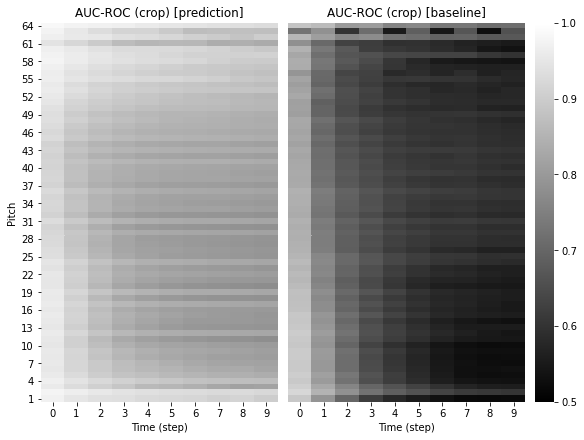

In [59]:
c1 = 0
c2 = 64
fig, (ax1, ax2, axcb) = plt.subplots(1, 3, constrained_layout=True,
                                     figsize=(8, 6),
                                     gridspec_kw={'width_ratios':[1, 1, 0.08]})
g1 = sns.heatmap(pred_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax1, cbar=False)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation=0)
ax1.set_xlabel('Time (step)')
ax1.set_ylabel('Pitch')
ax1.set_title('AUC-ROC (crop) [prediction]')
g2 = sns.heatmap(base_auc[c1:c2], vmin=0.5, vmax=1, cmap='gray', ax=ax2, cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
ax2.set_xlabel('Time (step)')
ax2.set_title('AUC-ROC (crop) [baseline]')
ax1.get_shared_y_axes().join(ax1,ax2)
# plt.savefig(PLOTS / 'heat_crop.eps', format='eps')
print(pred_auc.shape)

Predict. mean value: 0.8657782715311267
Baseline mean value: 0.650005876902954


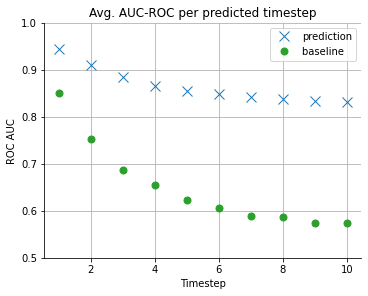

In [61]:
num_ts = 10
fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 4))

ax.plot(range(1, num_ts + 1), np.mean(pred_auc[c1:c2]), 'x', c='tab:blue', label='prediction', ms=10)
ax.plot(range(1, num_ts + 1), np.mean(base_auc[c1:c2]), 'o', c='tab:green', label='baseline ', ms=7)

ax.set_ylim([0.5, 1])
ax.set_ylim([0.5, 1])
ax.legend()
plt.title('Avg. AUC-ROC per predicted timestep')
plt.xlabel('Timestep')
# plt.xticks([0, 2, 4, 6, 8, 10])
plt.ylabel('ROC AUC')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
name = 'auc' + str()
plt.grid()
# plt.savefig(PLOTS / 'compare-lstm-auc.eps', format='eps')

print("Predict. mean value:", np.mean(np.mean(pred_auc[c1:c2])))
print("Baseline mean value:", np.mean(np.mean(base_auc[c1:c2])))

In [125]:
if SAVE:
    auc_df = pd.DataFrame(
        {'pred': np.mean(pred_auc[c1:c2]),
         'base': np.mean(base_auc[c1:c2])})
    auc_df['pred'].to_csv(('tables/rnn-' + D[5:] + '-auc-pred' + NOTES + '.dat').lower(), sep=' ', header=None)
    auc_df['base'].to_csv(('tables/rnn-' + D[5:] + '-auc-base' + NOTES + '.dat').lower(), sep=' ', header=None)

In [38]:
inp = []
lab = []
cnt = 0
print(test_data)
for input_batch, label_batch in test_data.take(100):
    print(input_batch.shape)
    inp.append(np.array(tf.squeeze(input_batch, 0)))
    lab.append(np.array(tf.squeeze(label_batch, 0)))
inp = np.array(inp)
print(inp.shape)
pyplot_piano_roll(inp[:, 0, :], cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)

<BatchDataset shapes: ((1, 50, 640), (1, 50, 640)), types: (tf.bool, tf.bool)>
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640)
(1, 50, 640

ValueError: The length of the second axis of `pianoroll` must be 128.

In [80]:
def generate_data(model, input_batch, size):
    generated = []
#     print(input_batch.shape)
    for i in range(size):
#         print(input_batch.shape)
        predictions = model(tf.cast(input_batch, tf.float32))
        pred = np.array(tf.squeeze(predictions, 0))
        predictions_bin = dataset.ranked_threshold(pred, steps=1, how_many=5)

        generated.append(np.array(predictions_bin[-1]))
        input_batch = tf.expand_dims([predictions_bin[-1]], 0)
    return np.array(generated)

In [81]:
model.reset_states()
predauc = []
baseauc = []

merged_input = []
merged_output = []
merged_pred = []

size = 10
import time


predizioni = []
a = 0
for input_batch, label_batch in test_data.take(-1):
#     print(input_batch.shape)
#     time.sleep(50)
#     print(a)
    a += 1

    generated = generate_data(model, input_batch, size)

    predizioni.append(generated)
#     print("OK")
#     inp = np.array(tf.squeeze(input_batch, 0))
#     out = np.array(tf.squeeze(label_batch, 0))

#     pyplot_piano_roll(out,
#                       cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
#     plt.title("Target")
#     plt.savefig(PLOTS / "roll1.png")

#     pyplot_piano_roll(pred,
#                       cmap="Purples", low_lim=LOW_LIM, high_lim=HIGH_LIM)
#     plt.title("Predictions")
#     plt.savefig(PLOTS / "roll.png")

#     pyplot_piano_roll(inp,
#                   cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)
#     plt.title("Baseline (repetition of the input)")
#     plt.savefig(PLOTS / "roll3.png")

#     pred_auc = ev_metrics.compute_auc(out, pred, NUM_NOTES)
#     base_auc = ev_metrics.compute_auc(out, inp, NUM_NOTES)
#     predauc.append(np.mean(np.mean(pred_auc)))
#     baseauc.append(np.mean(np.mean(base_auc)))

    
#     # Merged piano rolls to compute overall AUC.
# #     merged_input.append(inp)
# #     merged_output.append(out)
# #     merged_pred.append(pred)

# # merged_input = np.concatenate([x for x in merged_input])
# # merged_output = np.concatenate([x for x in merged_output])
# # merged_pred = np.concatenate([x for x in merged_pred])

# # pred_auc_merged = ev_metrics.compute_auc(merged_output, merged_pred, NUM_NOTES)
# # base_auc_merged = ev_metrics.compute_auc(merged_output, merged_input, NUM_NOTES)

# # print("Pred AUC-ROC (mean of subsets): ", np.mean(predauc))
# # print("Base AUC-ROC:(mean of subsets): ", np.mean(baseauc))

# # print("Pred AUC-ROC (global): ", np.mean(np.mean((pred_auc_merged))))
# # print("Base AUC-ROC (global): ", np.mean(np.mean((base_auc_merged))))

# predizioni = np.array(predizioni)
# print(predizioni.shape)

# # pyplot_piano_roll(test.dataset[1][:, :NUM_NOTES],
# #                   cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Test target (ground truth)")


# # plt.rcParams["figure.figsize"] = (13, 4)
# # pyplot_piano_roll(merged_output,
# #                   cmap="Greens", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Target (labels)")
# # plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll1.png")
# # pyplot_piano_roll(merged_pred[:, :NUM_NOTES],
# #                   cmap="Blues", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Predictions")
# # plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll2.png")
# # pyplot_piano_roll(merged_input[:, :NUM_NOTES],
# #                   cmap="Reds", low_lim=LOW_LIM, high_lim=HIGH_LIM)
# # plt.title("Baseline (equal to inputs)")
# # plt.ylim(CROP)
# # plt.savefig(PLOTS / "roll3.png")


In [78]:
for i in range(10):
    pyplot_piano_roll(predizioni[:, i, :], low_lim=LOW_LIM, high_lim=HIGH_LIM)

NameError: name 'predizioni' is not defined